### In-Class Exercise 1: Load the clean communitiy crime data

- Create a dataframe for predictor and response variables
- Scale the predictor variables as done in Feature Engineering 1 - Principal Components
why scaled: principal component
            don't want any predictor to dominate

In [1]:
# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp

# Analytics and modeling
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.sandbox.tools.tools_pca as sm_pca
from statsmodels.formula.api import ols as sm_ols
from statsmodels.stats.anova import anova_lm as sm_anova
from patsy.contrasts import Treatment
from patsy import dmatrices

# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig

# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

/Users/Pan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Pan/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
path = '/Users/Pan/Google Drive/Data Science/DS6001/'
file = 'CommunityCrimeDataRaw.txt'

crimes_df = pd.read_csv(path+file,header = None,na_values = '?')

crimes_df.shape

(2215, 147)

In [4]:
header_file = 'CrimeVariableLabels.txt'
crimes_header = pd.read_csv(path+header_file,header=None)
crimes_df.columns = crimes_header.loc[:,0]

crimes_df.head(3)

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51


In [5]:
# get rid of the non-predictor variable
crimes_df.drop(['communityname','state','countyCode','communityCode','fold'],axis = 1,inplace=True)

crimes_df.shape

(2215, 142)

In [6]:
crimes_df.dropna(axis=1,thresh = 1215,inplace = True)
crimes_df.shape

(2215, 120)

In [7]:
# here is a class that will provide imputation
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        
        Columns of dtype floating point are imputed with the mean.

        Columns of other types are imputed with median of the column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') 
                               else X[c].mean() if X[c].dtype == np.dtype('f')
                                else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



In [8]:
# doing the imputation
crimes_df = DataFrameImputer().fit_transform(crimes_df)
crimes_df.isnull().sum()

0
population               0
householdsize            0
racepctblack             0
racePctWhite             0
racePctAsian             0
racePctHisp              0
agePct12t21              0
agePct12t29              0
agePct16t24              0
agePct65up               0
numbUrban                0
pctUrban                 0
medIncome                0
pctWWage                 0
pctWFarmSelf             0
pctWInvInc               0
pctWSocSec               0
pctWPubAsst              0
pctWRetire               0
medFamInc                0
perCapInc                0
whitePerCap              0
blackPerCap              0
indianPerCap             0
AsianPerCap              0
OtherPerCap              0
HispPerCap               0
NumUnderPov              0
PctPopUnderPov           0
PctLess9thGrade          0
                        ..
MedOwnCostPctIncNoMtg    0
NumInShelters            0
NumStreet                0
PctForeignBorn           0
PctBornSameState         0
PctSameHouse85           0

In [9]:
# start of the response variable
response_start = crimes_df.columns.get_loc('murders')

# list of per pop columns
cols = list(range(response_start+1, 118, 2))

# adding the last two response variables
cols.extend([118,119])

# final list
crimes_df.columns[cols]

Index(['murdPerPop', 'rapesPerPop', 'robbbPerPop', 'assaultPerPop',
       'burglPerPop', 'larcPerPop', 'autoTheftPerPop', 'arsonsPerPop',
       'ViolentCrimesPerPop', 'nonViolPerPop'],
      dtype='object', name=0)

In [10]:
# dataframe of the response variables
crimes_response_df = crimes_df[crimes_df.columns[cols]]
crimes_response_df.describe()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2215.000000,2215.000000,2215.000000,2215.00000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,5.859296,35.381549,162.572953,377.11556,1033.144810,3372.581675,473.733199,31.698736,567.625567,4887.099228
std,9.156829,32.705405,234.441088,437.10334,762.876468,1900.058222,504.363503,38.488835,586.844780,2680.842377
min,0.000000,0.000000,0.000000,0.00000,16.920000,77.860000,6.550000,0.000000,0.000000,116.790000
25%,0.000000,13.390000,27.655000,94.75000,512.185000,2040.740000,157.060000,7.985000,185.280000,2994.265000
50%,2.170000,26.920000,74.800000,226.52500,822.715000,3079.510000,302.355000,21.080000,374.060000,4425.450000
75%,8.365000,48.705000,187.150000,502.61500,1348.670000,4334.675000,589.225000,41.435000,722.000000,6100.870000
max,91.090000,401.350000,2264.130000,4932.50000,11881.020000,25910.550000,4968.590000,436.370000,4877.060000,27119.760000


In [11]:
# scale the response variables to 0,100
# needed for PCA
from sklearn.preprocessing import MinMaxScaler

cols = crimes_response_df.columns
scaler = MinMaxScaler(feature_range=(0,100))
response_scaled_df = \
pd.DataFrame(scaler.fit_transform(crimes_response_df),columns = cols)

response_scaled_df.describe()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,6.432425,8.815634,7.180372,7.645526,8.565545,12.754079,9.415144,7.264188,11.638683,17.665869
std,10.052507,8.148849,10.354577,8.861700,6.430125,7.355247,10.164438,8.820229,12.032757,9.927954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.336240,1.221440,1.920933,4.174484,7.598434,3.033228,1.829869,3.799010,10.656143
50%,2.382259,6.707363,3.303697,4.592499,6.791876,11.619580,5.961359,4.830763,7.669785,15.956245
75%,9.183225,12.135293,8.265868,10.189863,11.225040,16.478404,11.742650,9.495382,14.804001,22.160822
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [12]:
# get predictor DF
crimes_predictors_df = crimes_df.loc[:,:'LemasPctOfficDrugUn']
crimes_predictors_df.shape

(2215, 102)

In [13]:
# get the variables with max values > 1k and then the others
preds2scale = crimes_predictors_df.columns[crimes_predictors_df.apply('max',axis = 0)>1e3]
preds2notscale = crimes_predictors_df.columns[crimes_predictors_df.apply('max',axis = 0)<=1e3]

print(preds2scale)
print(preds2notscale)

Index(['population', 'numbUrban', 'medIncome', 'medFamInc', 'perCapInc',
       'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap',
       'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'NumKidsBornNeverMar',
       'NumImmig', 'HousVacant', 'MedYrHousBuilt', 'OwnOccLowQuart',
       'OwnOccMedVal', 'OwnOccHiQuart', 'OwnOccQrange', 'RentLowQ',
       'RentMedian', 'RentHighQ', 'MedRent', 'NumInShelters', 'NumStreet',
       'LandArea', 'PopDens'],
      dtype='object', name=0)
Index(['householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian',
       'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24',
       'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc',
       'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'PctPopUnderPov',
       'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed',
       'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu',
       'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv',
       

In [14]:
# scale the predictions with large values (>1k)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,100))
scaled_df = \
pd.DataFrame(scaler.fit_transform(crimes_predictors_df[preds2scale]),columns = preds2scale)

scaled_df.describe()

,population,numbUrban,medIncome,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,...,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,MedRent,NumInShelters,NumStreet,LandArea,PopDens
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,0.589575,0.651885,21.888215,22.876343,17.853310,17.507177,5.441142,2.547748,13.401770,6.892115,...,24.823656,17.106482,25.606052,35.021254,42.155412,38.252950,0.286334,0.170609,0.743085,6.272821
std,2.798203,2.807851,11.698150,11.085170,10.818150,10.014264,4.352302,3.094549,9.307461,5.784468,...,20.989975,11.814652,15.979874,19.376464,24.333429,20.923577,2.413091,2.349503,3.077211,6.397557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.059637,0.000000,13.028172,14.849760,10.962714,11.263372,3.178625,1.321875,7.804361,4.035401,...,9.771069,9.728097,12.694013,19.239501,22.466422,21.260816,0.000000,0.000000,0.179327,2.650164
50%,0.174864,0.246375,19.671660,20.403544,15.265651,15.148790,4.609183,2.061458,11.538643,5.975182,...,16.638371,13.111782,23.059867,31.441544,37.118437,33.992583,0.000000,0.000000,0.358654,4.561973
75%,0.451538,0.572450,28.419993,28.431639,21.627486,20.728802,6.848011,3.074479,16.321292,8.412409,...,33.870212,19.773414,35.698448,48.127128,58.302808,52.286774,0.094085,0.009572,0.706100,7.489162
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [15]:
# joining both dataframes
crimes_scaled_preds_df = pd.concat([scaled_df,crimes_predictors_df[preds2notscale]],axis=1)

crimes_scaled_preds_df.shape

(2215, 102)

### In-Class Exercise 2 

- Get two tSNE components for the scaled predictors using the default values for the hyperparameters
- Plot the observations in these components
- Plot the observations in these components with the violent crimes cut using the box plot statistics
- Plot the observations in these components with the nonviolent crimes cut using the box plot statistics
- Plot the observations in these components with one of the other response variables

In [43]:
from sklearn.manifold import TSNE
# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42)

crimes_tsne = tsne.fit_transform(crimes_scaled_preds_df)

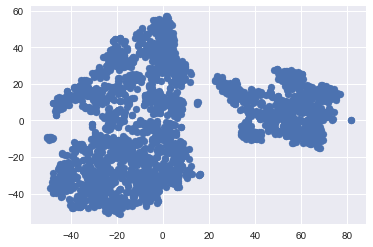

In [44]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

[0.0, 185.28, 374.06, 722.0, 1523.9200000000001]


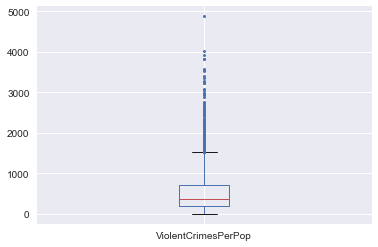

In [45]:
# Violent crime categorical variable
# communities with different levels
# of violent crime defined by the box plot rule

crimesbox = crimes_response_df.boxplot(column = 'ViolentCrimesPerPop',return_type = 'dict', sym = 'b.')

# box plots stats
crimesbox_stats = [crimesbox['whiskers'][0].get_ydata()[1], # lower whisker
                crimesbox['boxes'][0].get_ydata()[0], # lower box 25%
                crimesbox['medians'][0].get_ydata()[0], # median
                crimesbox['boxes'][0].get_ydata()[2], # upper box 75%
                crimesbox['whiskers'][1].get_ydata()[1] # upper whisker
               ]
print(crimesbox_stats)

In [46]:
crime_labels = ['Great','Ok','Neutral','Bad','Very Bad']

In [47]:
bins=crimesbox_stats
bins.append(crimes_response_df['ViolentCrimesPerPop'].max())
bins

[0.0, 185.28, 374.06, 722.0, 1523.9200000000001, 4877.0600000000004]

In [48]:
Violent_Crime = pd.cut(crimes_response_df['ViolentCrimesPerPop'],bins,labels = crime_labels)

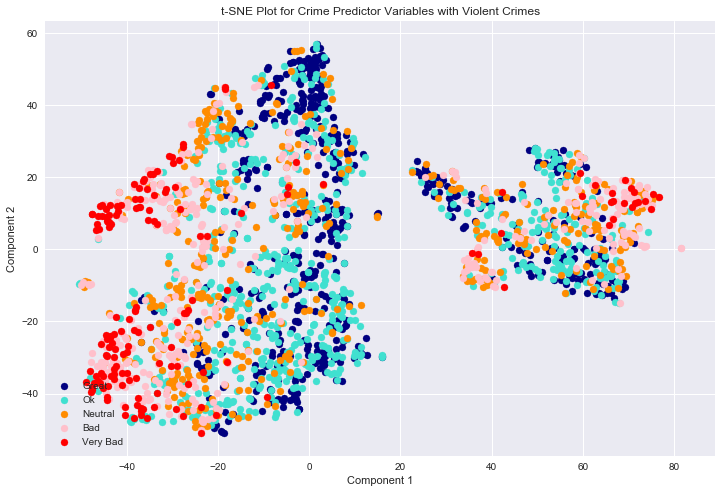

In [49]:
# tsne plot with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12, 8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[Violent_Crime == i, 0],
                   crimes_tsne[Violent_Crime == i, 1], c = color, label=i)
    
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Violent Crimes')


### In-Class Exercise 3 

- Get two tSNE components for the scaled predictors using perplexity values of 5 and 100
- Plot the observations in these components
- Plot the observations in these components with the violent crimes cut using the box plot statistics
- Plot the observations in these components with the nonviolent crimes cut using the box plot statistics
- Plot the observations in these components with one of the other response variables

In [50]:
#perplexity = 5

from sklearn.manifold import TSNE
# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42,perplexity=5)

crimes_tsne = tsne.fit_transform(crimes_scaled_preds_df)

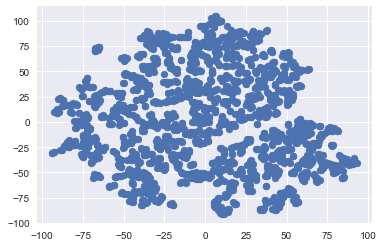

In [51]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

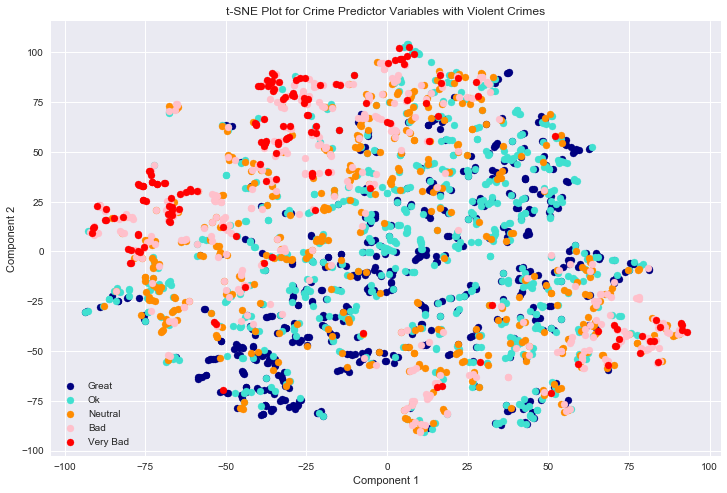

In [52]:
# tsne plot with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12, 8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[Violent_Crime == i, 0],
                   crimes_tsne[Violent_Crime == i, 1], c = color, label=i)
    
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Violent Crimes')

[116.79000000000001, 2994.2650000000003, 4425.4500000000007, 6100.8699999999999, 10739.530000000001]


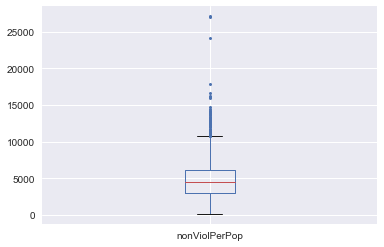

In [53]:
# non-violent crime categorical variable
# communities with different levels
# of non-violent crime defined by the box plot rule

nonviolcrimesbox = crimes_response_df.boxplot(column = 'nonViolPerPop',return_type = 'dict', sym = 'b.')
# box plots stats
nonviolcrimesbox_stats = [nonviolcrimesbox['whiskers'][0].get_ydata()[1], # lower whisker
                nonviolcrimesbox['boxes'][0].get_ydata()[0], # lower box 25%
                nonviolcrimesbox['medians'][0].get_ydata()[0], # median
                nonviolcrimesbox['boxes'][0].get_ydata()[2], # upper box 75%
                nonviolcrimesbox['whiskers'][1].get_ydata()[1] # upper whisker
               ]
print(nonviolcrimesbox_stats)

In [54]:
# get the bins
bins = nonviolcrimesbox_stats
bins.append(crimes_response_df['nonViolPerPop'].max())
bins

[116.79000000000001,
 2994.2650000000003,
 4425.4500000000007,
 6100.8699999999999,
 10739.530000000001,
 27119.759999999998]

In [55]:
NonViolent_Crime = pd.cut(crimes_response_df['nonViolPerPop'],bins,labels = crime_labels)

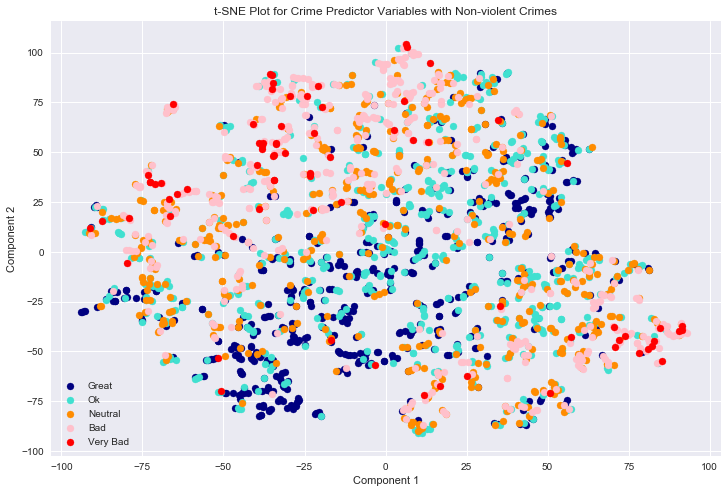

In [56]:
# tsne plot with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12, 8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[NonViolent_Crime == i, 0],
                   crimes_tsne[NonViolent_Crime == i, 1], c = color, label=i)
    
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Non-violent Crimes')

[0.0, 0.0, 2.1699999999999999, 8.3649999999999984, 20.879999999999999]


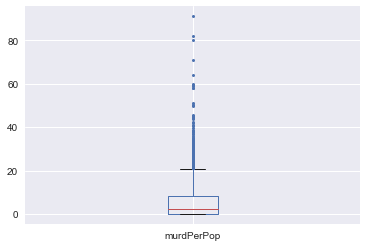

In [57]:
# murder as categorical variable
# communities with different levels of murder defined by box plot rule

murderbox = crimes_response_df.boxplot(column = 'murdPerPop',return_type = 'dict', sym = 'b.')
# box plots stats
murderbox_stats = [murderbox['whiskers'][0].get_ydata()[1], # lower whisker
                murderbox['boxes'][0].get_ydata()[0], # lower box 25%
                murderbox['medians'][0].get_ydata()[0], # median
                murderbox['boxes'][0].get_ydata()[2], # upper box 75%
                murderbox['whiskers'][1].get_ydata()[1] # upper whisker
               ]
print(murderbox_stats)

In [58]:
# get the bins
# notice lower box = lower whisker
bins = murderbox_stats[1:] # drop lower whisker
bins.append(crimes_response_df['murdPerPop'].max())
bins

[0.0,
 2.1699999999999999,
 8.3649999999999984,
 20.879999999999999,
 91.090000000000003]

In [59]:
# drop one label
crime_labels = ['Ok','Neutral','Bad','Very Bad']

Murder = pd.cut(crimes_response_df['murdPerPop'],bins,labels = crime_labels)

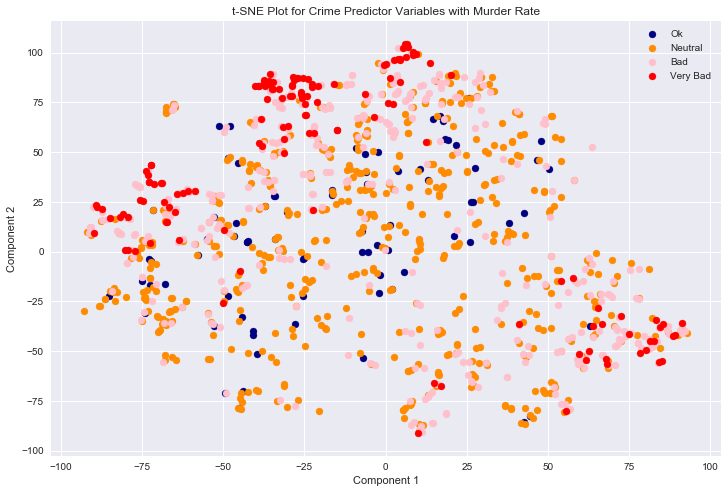

In [60]:
# tsne plot with labels for murder towns
# drop a color
colors = ['navy','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12,8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[Murder == i, 0],
                   crimes_tsne[Murder == i, 1], c = color, label=i)
    
ax.legend(loc = 1)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Murder Rate')

In [61]:
#perplexity = 100

from sklearn.manifold import TSNE
# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42,perplexity=100)

crimes_tsne = tsne.fit_transform(crimes_scaled_preds_df)

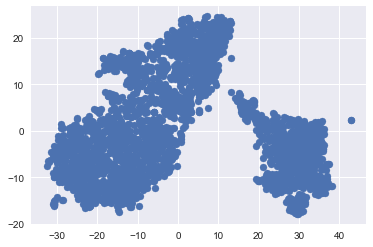

In [62]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

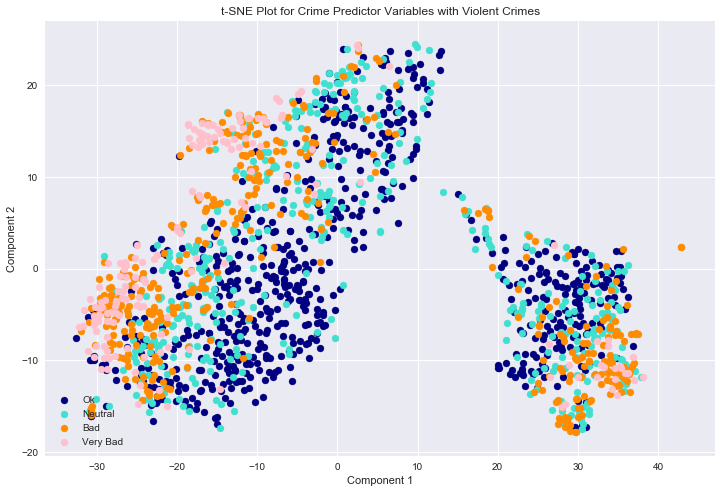

In [63]:
# tsne plot with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12, 8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[Violent_Crime == i, 0],
                   crimes_tsne[Violent_Crime == i, 1], c = color, label=i)
    
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Violent Crimes')

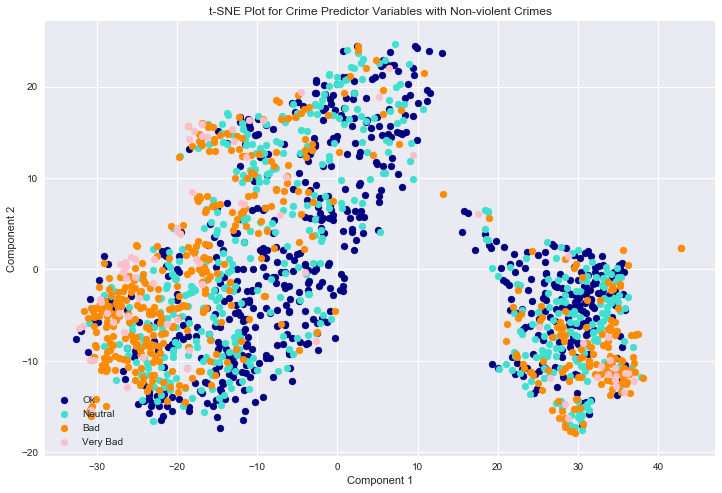

In [64]:
# tsne plot with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12, 8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[NonViolent_Crime == i, 0],
                   crimes_tsne[NonViolent_Crime == i, 1], c = color, label=i)
    
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Non-violent Crimes')

In [65]:
# drop one label
crime_labels = ['Ok','Neutral','Bad','Very Bad']

Murder = pd.cut(crimes_response_df['murdPerPop'],bins,labels = crime_labels)

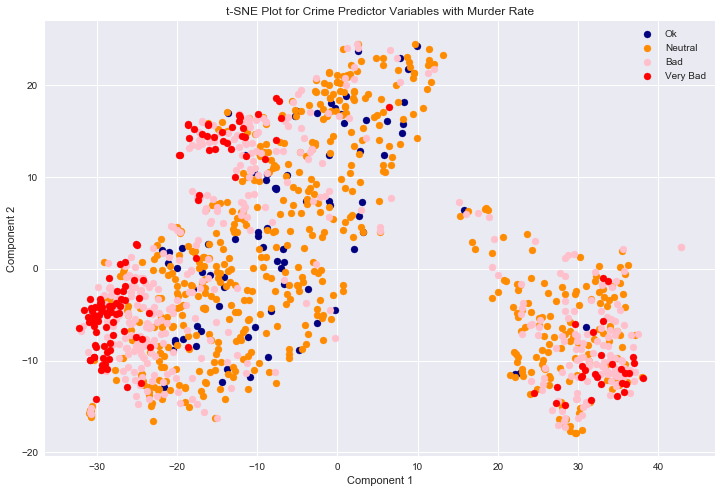

In [66]:
# tsne plot with labels for murder towns
# drop a color
colors = ['navy','darkorange','pink','red']

fig, ax = plt.subplots(figsize=(12,8))
for i, color in  zip(crime_labels,colors):
        ax.scatter(crimes_tsne[Murder == i, 0],
                   crimes_tsne[Murder == i, 1], c = color, label=i)
    
ax.legend(loc = 1)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot for Crime Predictor Variables with Murder Rate')

### In-Class Exercise 4 

- Get two tSNE components for the scaled predictors with log transformations using at least two different values for the hyperparameters
- Plot the observations in these components
- Plot the observations in these components with the violent crimes cut using the box plot statistics
- Plot the observations in these components with the nonviolent crimes cut using the box plot statistics
- Plot the observations in these components with one of the other response variables

# Perplexity = 30

In [67]:

# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42,perplexity=30)

# log tranform the predictors
log_crimes_preds_df = np.log(crimes_scaled_preds_df +.1)
log_crimes_tsne = tsne.fit_transform(log_crimes_preds_df)

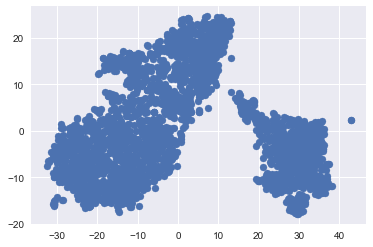

In [68]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

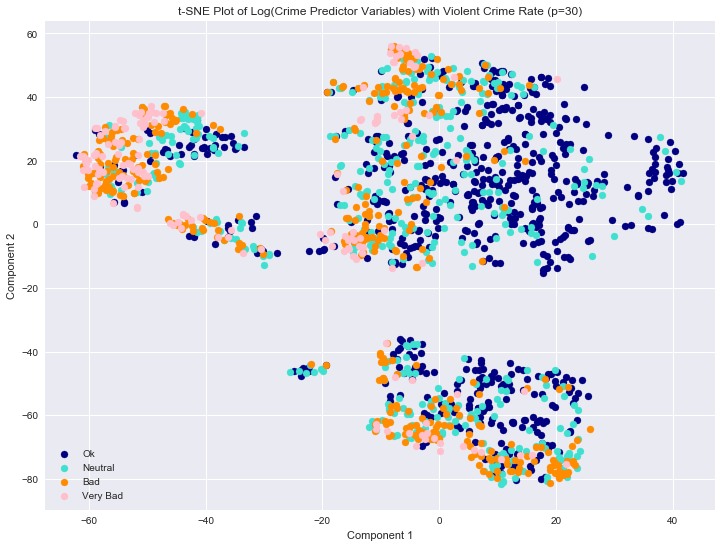

In [69]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,9))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[Violent_Crime == i, 0],
                   log_crimes_tsne[Violent_Crime == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with Violent Crime Rate (p=30)')


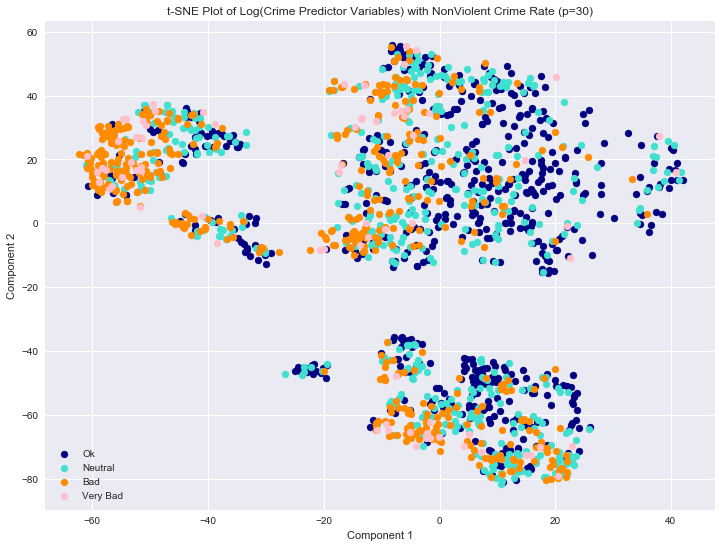

In [70]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,9))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[NonViolent_Crime == i, 0],
                   log_crimes_tsne[NonViolent_Crime == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with NonViolent Crime Rate (p=30)')

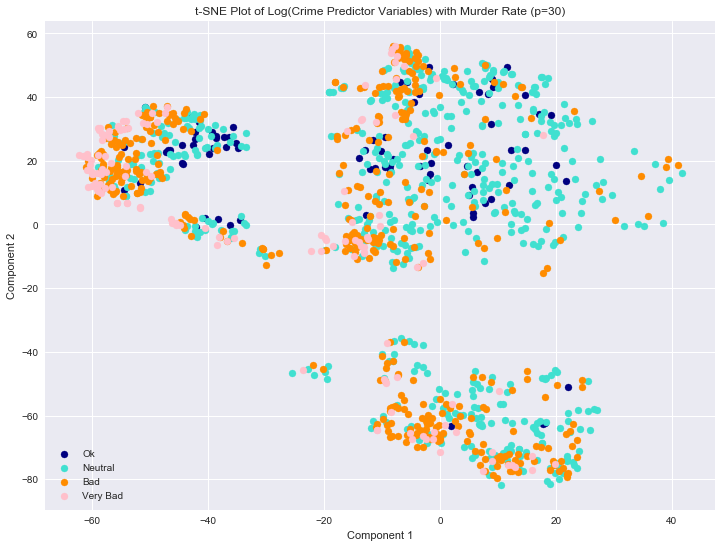

In [71]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,9))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[Murder == i, 0],
                   log_crimes_tsne[Murder == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with Murder Rate (p=30)')



# Perplexity = 200

In [72]:
from sklearn.manifold import TSNE
# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random',
                         random_state=42,perplexity=200)

# log tranform the predictors
log_crimes_preds_df = np.log(crimes_scaled_preds_df +.1)
log_crimes_tsne = tsne.fit_transform(log_crimes_preds_df)

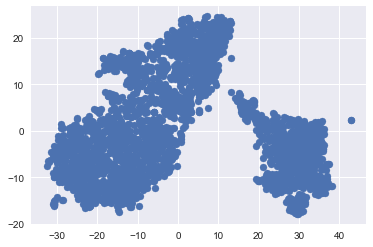

In [73]:
plt.scatter(crimes_tsne[:,0], crimes_tsne[:,1])

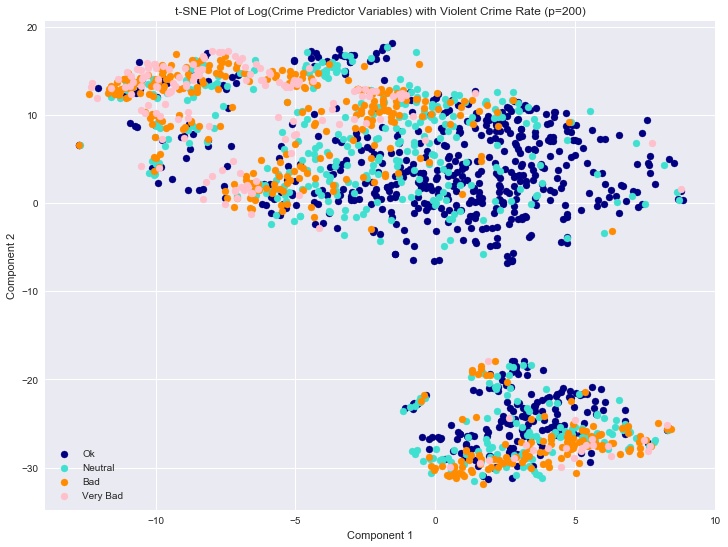

In [74]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,9))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[Violent_Crime == i, 0],
                   log_crimes_tsne[Violent_Crime == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with Violent Crime Rate (p=200)')

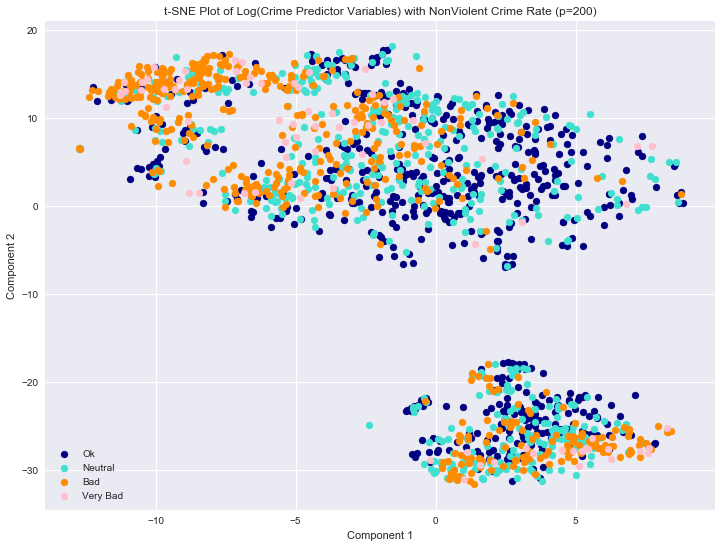

In [75]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,9))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[NonViolent_Crime == i, 0],
                   log_crimes_tsne[NonViolent_Crime == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with NonViolent Crime Rate (p=200)')

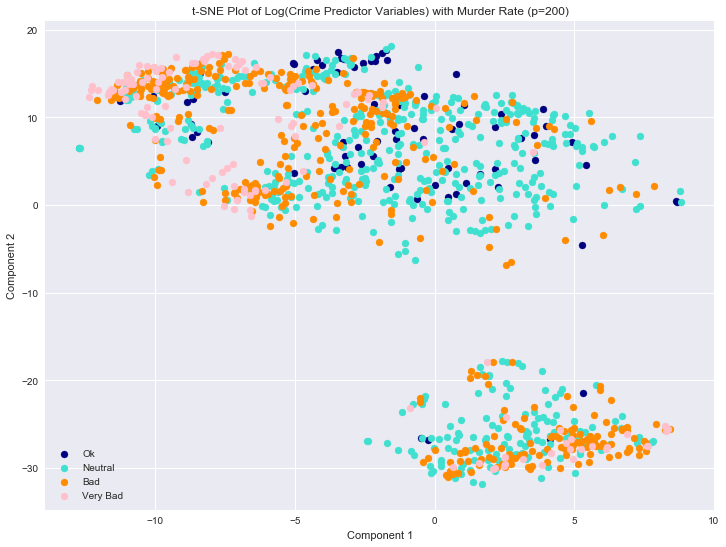

In [76]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,9))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[Murder == i, 0],
                   log_crimes_tsne[Murder == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with Murder Rate (p=200)')


### In-Class Exercise 5

- Insert a principal component and comparable t-SNE plot
- Compare and contrast these two plots using criteria of your choosing

perplexity 100:
very similar for violent and non-violent

murder:high concentration (red)
tsne: there is some non-linearity

# PCA plot for Log Crime Predictor Variables) with Murder Rate


In [77]:
# perform PCA for predictor variables


n = len(crimes_predictors_df.columns)

pca = PCA(n_components = n)

# log tranform the predictors
log_crimes_preds_df = np.log(crimes_scaled_preds_df +.1)
log_crimes_preds_pca = pca.fit_transform(log_crimes_preds_df)


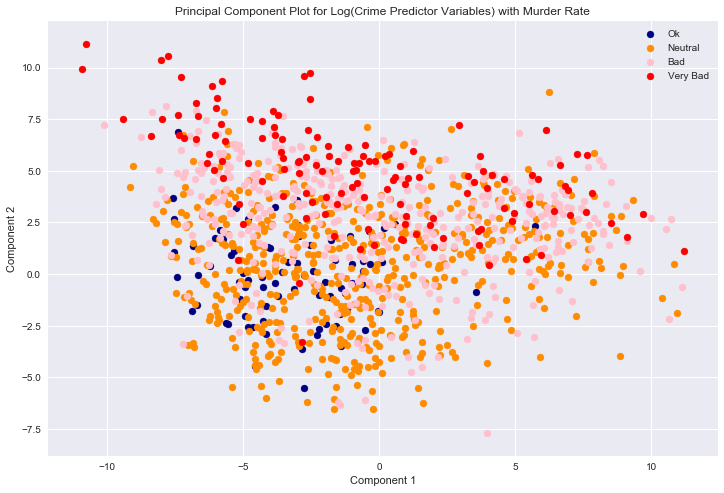

In [78]:
# drop a color
colors = ['navy','darkorange','pink','red']

fig, ax = plt.subplots(figsize =(12,8))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_preds_pca[Murder == i, 0],
                   log_crimes_preds_pca[Murder == i, 1], c = color, label=i)
        
    
ax.legend(loc = 1)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot for Log(Crime Predictor Variables) with Murder Rate')

# tSNE plot for Log Crime Predictor Variables) with Murder Rate (p=200)

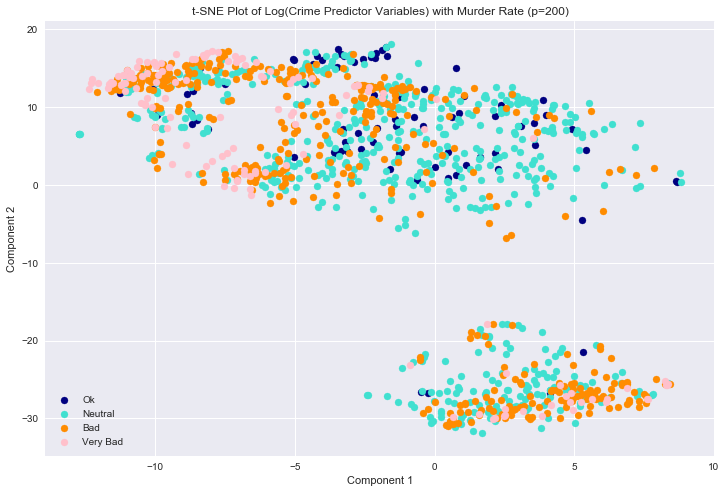

In [79]:
# TSNE Plots with labels for murder towns
colors = ['navy','turquoise','darkorange','pink','red']

fig, ax = plt.subplots(figsize = (12,8))
for i, color in  zip(crime_labels, colors):
        ax.scatter(log_crimes_tsne[Murder == i, 0],
                   log_crimes_tsne[Murder == i, 1], c = color, label=i)
        
ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('t-SNE Plot of Log(Crime Predictor Variables) with Murder Rate (p=200)')